In [1]:
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer

## Data

The following two code cells generate graph data for a binary tree and Zachary's karate club network, respectively. Only run one of the two cells.

In [2]:
# h : graph edges as (origin, destination, distance)
h = [
    (0,1,1),(0,2,1),
    (1,3,1),(1,4,1),(2,5,1),(2,6,1),
    (3,7,1),(3,8,1),(4,9,1),(4,10,1),(5,11,1),(5,12,1),(6,13,1),(6,14,1)
]

H = nx.Graph()
for src, dst, wt in h:
    H.add_edge(src, dst, weight=wt)

nodes = list(H.nodes)
num_nodes = len(nodes)

# triples: shortest paths between pairs of nodes as (origin, destination, shortest distance)
triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            orig = nodes[i]
            dest = nodes[j]
            dist = nx.shortest_path_length(H, orig, dest, weight='weight')
            triples.append((orig, dest, dist))
        except Exception:
            pass

pairs = [[orig, dest] for orig, dest, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[dist for _,_,dist in triples]
graph_distance = torch.tensor(graph_distance)

In [3]:
H = nx.karate_club_graph()

nodes = list(H.nodes)
num_nodes = len(nodes)

triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            a = nodes[i]
            b = nodes[j]
            dist = nx.shortest_path_length(H, a, b, weight='weight')
            triples.append((a, b, dist))
        except Exception:
            pass

pairs = [[a, b] for a, b, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[d for _,_,d in triples]
graph_distance = torch.tensor(graph_distance)

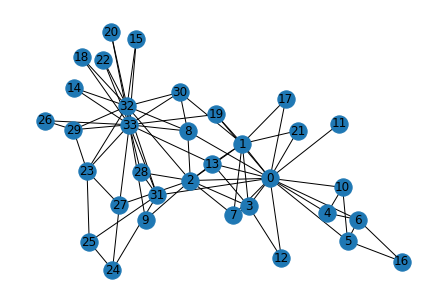

In [4]:
nx.draw(H, with_labels=True, pos=nx.spring_layout(H))

## Geometry

In [5]:
minimum_norm = 1e-10
epsilon = 1e-4

def expmap(p, v):
    return p + v # this is a retraction

def proj(x):
    norm = torch.clamp_min(torch.norm(x, dim=-1, keepdim=True), minimum_norm)
    cond = norm >= 1
    projected = x / norm - epsilon
    return torch.where(cond, projected, x)

def egrad2rgrad(p, d_p):
    '''
    Translate a Euclidean gradient d_p to the Riemannian gradient on the tangent space of p
    '''
    p_sqnorm = torch.sum(p ** 2, dim=-1, keepdim=True)
    return d_p * ((1 - p_sqnorm) ** 2 / 4).expand_as(d_p)

class RiemannianSGD(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(RiemannianSGD, self).__init__(params, defaults)

    def step(self, lr=None):
        for group in self.param_groups:
            for p in group['params']:
                lr = lr or group['lr']

                if p.grad is None:
                    continue

                d_p = egrad2rgrad(p.data, p.grad.data)
                d_p.mul_(-lr)
                p_new = proj(expmap(p.data, d_p))

                p.data.copy_(p_new)

In [6]:
def distortion(graph_distances, hyperbolic_distances):
    loss = torch.pow(torch.div(hyperbolic_distances, graph_distances), 2)
    loss = torch.abs(loss - 1)
    loss = loss.sum()
    return loss

## Model Definition

In [7]:
class PoincareBall:
    def __init__(self):
        pass

    def distance(self, x, y):
        u = 2 * torch.clamp_min(torch.norm(x - y, 2, 1)**2, 1e-5) # for when x ~ y (otherwise gradient will vanish/explode)
        d = 1. + torch.div(u, torch.clamp_min((1 - torch.norm(x, 2, 1)**2) * (1 - torch.norm(y, 2, 1)**2), 1e-5))
        return torch.acosh(d)

In [8]:
class Embedding(nn.Module):
    def __init__(self, number_points):
        super().__init__()
        # naive initialization
        self._embedding = torch.nn.parameter.Parameter(data=torch.rand([number_points, 2])-0.5)

    def forward(self, node_index):
        return self._embedding[node_index]

In [9]:
class Model(nn.Module):
    def __init__(self, number_points):
        super().__init__()
        self.manifold = PoincareBall()
        self.embedding = Embedding(number_points)

    def forward(self, node_index_pairs):
        nodes1_indices, nodes2_indices = node_index_pairs[:,0], node_index_pairs[:,1]
        nodes1_embeddings = self.embedding(nodes1_indices)
        nodes2_embeddings = self.embedding(nodes2_indices)
        return self.manifold.distance(nodes1_embeddings, nodes2_embeddings)

## Training the Model

In [10]:
torch.autograd.set_detect_anomaly(True)

In [11]:
model = Model(num_nodes)
optimizer = RiemannianSGD(model.parameters(), lr=0.01)

In [12]:
for epoch in range(2000):
    optimizer.zero_grad()
    manifold_dist = model(pairs)
    loss = distortion(graph_distance, manifold_dist)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        #print(epoch, loss.item())
        print("Epoch: {}.\tLoss: {}.".format(epoch, loss.item()))

Epoch: 0.	Loss: 455.9263916015625.
Epoch: 100.	Loss: 273.108154296875.
Epoch: 200.	Loss: 230.89111328125.
Epoch: 300.	Loss: 149.1118927001953.
Epoch: 400.	Loss: 150.91970825195312.
Epoch: 500.	Loss: 148.13856506347656.
Epoch: 600.	Loss: 145.59446716308594.
Epoch: 700.	Loss: 149.77127075195312.
Epoch: 800.	Loss: 152.17115783691406.
Epoch: 900.	Loss: 143.2874755859375.
Epoch: 1000.	Loss: 147.25807189941406.
Epoch: 1100.	Loss: 145.85580444335938.
Epoch: 1200.	Loss: 147.05831909179688.
Epoch: 1300.	Loss: 142.25955200195312.
Epoch: 1400.	Loss: 145.92520141601562.
Epoch: 1500.	Loss: 147.85935974121094.
Epoch: 1600.	Loss: 143.54164123535156.
Epoch: 1700.	Loss: 144.86880493164062.
Epoch: 1800.	Loss: 145.69546508789062.
Epoch: 1900.	Loss: 148.8602294921875.


## Model Inspection

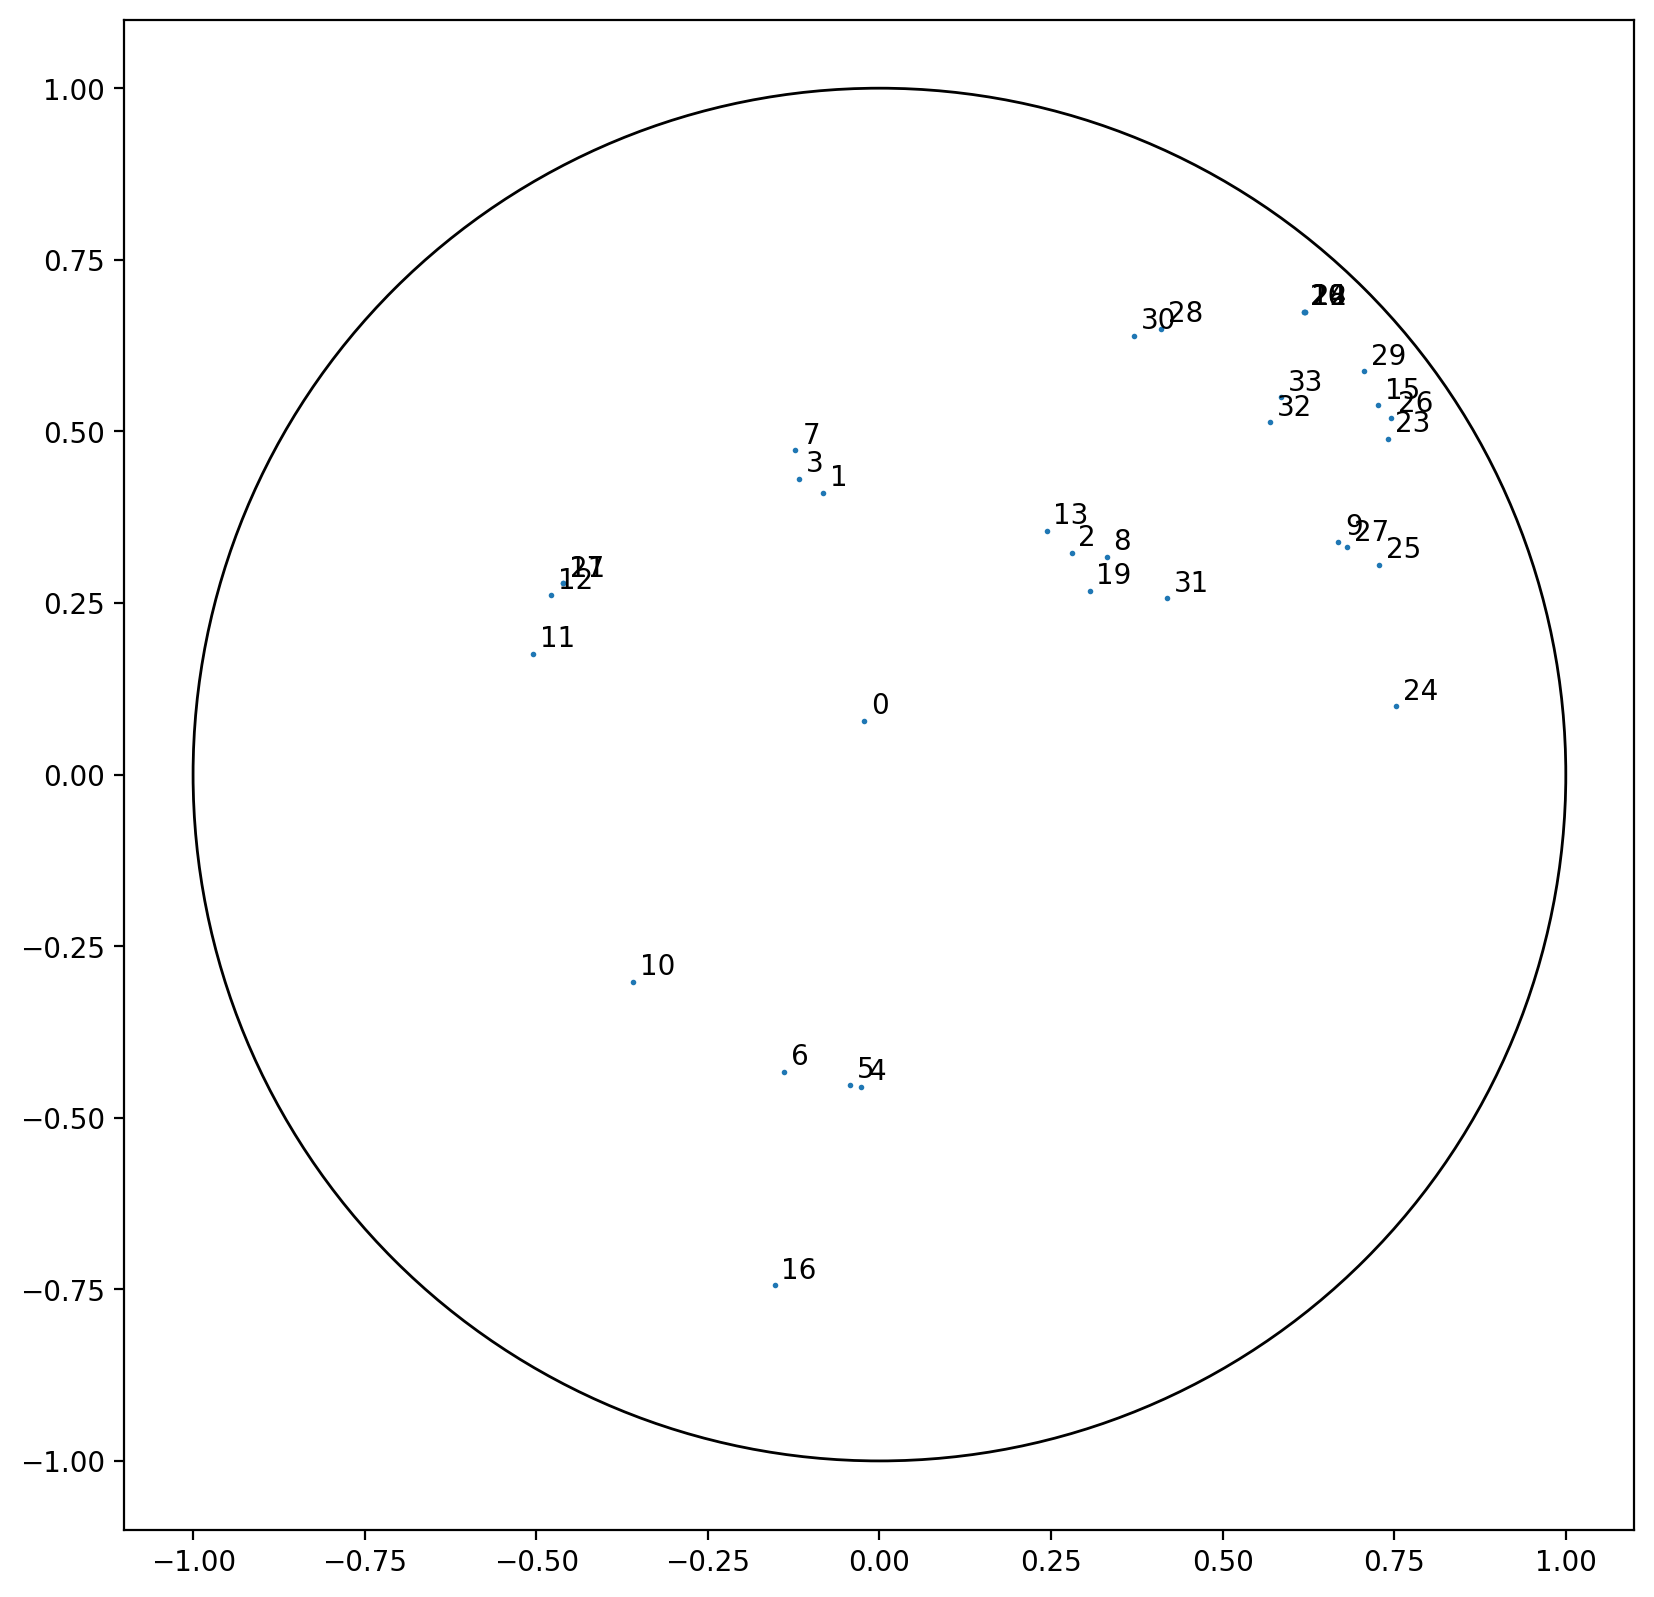

In [13]:
x = model.embedding._embedding[:,0].detach().numpy()
y = model.embedding._embedding[:,1].detach().numpy()

plt.figure(figsize=(10, 10), dpi=200)
circle1 = plt.Circle((0, 0), 1, fill=False)
plt.scatter(x, y, s=1)
plt.gca().add_patch(circle1)

ax = plt.gca()
for i, txt in enumerate(nodes):
    ax.annotate(txt, (x[i] + 0.01, y[i] + 0.01))

ax.set_aspect(1)

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

embedding._embedding tensor([[-0.0221,  0.0784],
        [-0.0822,  0.4109],
        [ 0.2798,  0.3233],
        [-0.1177,  0.4312],
        [-0.0262, -0.4547],
        [-0.0423, -0.4519],
        [-0.1394, -0.4332],
        [-0.1224,  0.4728],
        [ 0.3309,  0.3176],
        [ 0.6684,  0.3392],
        [-0.3595, -0.3017],
        [-0.5047,  0.1761],
        [-0.4780,  0.2611],
        [ 0.2434,  0.3555],
        [ 0.6194,  0.6741],
        [ 0.7270,  0.5378],
        [-0.1527, -0.7438],
        [-0.4616,  0.2791],
        [ 0.6188,  0.6745],
        [ 0.3062,  0.2681],
        [ 0.6179,  0.6744],
        [-0.4614,  0.2790],
        [ 0.6196,  0.6741],
        [ 0.7410,  0.4894],
        [ 0.7527,  0.0995],
        [ 0.7273,  0.3058],
        [ 0.7455,  0.5191],
        [ 0.6818,  0.3313],
        [ 0.4099,  0.6496],
        [ 0.7057,  0.5880],
        [ 0.3703,  0.6396],
        [ 0.4189,  0.2568],
        [ 0.5684,  0.5137],
        [ 0.5844,  0.5497]])


In [15]:
for i, pair in enumerate(pairs):
    # pair, graph distance, embedding distance
    print(pairs[i].detach().numpy(), graph_distance[i].item(), round(model(pair.reshape(1, -1)).item(), 1))

[0 1] 1 0.7
[0 2] 1 0.8
[0 3] 1 0.8
[0 4] 1 1.1
[0 5] 1 1.1
[0 6] 1 1.1
[0 7] 1 0.9
[0 8] 1 0.9
[0 9] 2 1.9
[ 0 10] 1 1.1
[ 0 11] 1 1.1
[ 0 12] 1 1.1
[ 0 13] 1 0.8
[ 0 14] 3 3.0
[ 0 15] 3 2.9
[ 0 16] 2 2.1
[ 0 17] 1 1.1
[ 0 18] 3 3.0
[ 0 19] 1 0.8
[ 0 20] 3 3.0
[ 0 21] 1 1.1
[ 0 22] 3 3.0
[ 0 23] 3 2.8
[ 0 24] 2 2.0
[ 0 25] 2 2.1
[ 0 26] 3 3.0
[ 0 27] 2 2.0
[ 0 28] 2 1.9
[ 0 29] 3 3.1
[ 0 30] 2 1.8
[ 0 31] 1 1.0
[ 0 32] 2 2.0
[ 0 33] 2 2.1
[1 2] 1 0.9
[1 3] 1 0.1
[1 4] 2 1.9
[1 5] 2 1.9
[1 6] 2 1.8
[1 7] 1 0.2
[1 8] 2 1.0
[1 9] 2 2.1
[ 1 10] 2 1.7
[ 1 11] 2 1.2
[ 1 12] 2 1.1
[ 1 13] 1 0.8
[ 1 14] 3 2.9
[ 1 15] 3 3.0
[ 1 16] 3 2.8
[ 1 17] 1 1.0
[ 1 18] 3 2.9
[ 1 19] 1 1.0
[ 1 20] 3 2.9
[ 1 21] 1 1.0
[ 1 22] 3 2.9
[ 1 23] 3 2.9
[ 1 24] 3 2.4
[ 1 25] 3 2.3
[ 1 26] 3 3.1
[ 1 27] 2 2.2
[ 1 28] 2 1.7
[ 1 29] 3 3.1
[ 1 30] 1 1.5
[ 1 31] 2 1.2
[ 1 32] 2 1.9
[ 1 33] 2 2.1
[2 3] 1 1.0
[2 4] 2 1.8
[2 5] 2 1.8
[2 6] 2 1.9
[2 7] 1 1.0
[2 8] 1 0.1
[2 9] 1 1.2
[ 2 10] 2 1.9
[ 2 11] 2 1.8
[ 2 12] 2 1.

## TODO

* Carry out model evaluation
* Write a proper initializer for `Embedding()` model parameters
* Implement an optimizer that recognizes the different types of layers and updates parameters using the appropriate gradient. (The current RiemannianSGD() optimizer converts all gradients to Poincare ball gradients.)
* Implement a scheduler to adjust the learning rate
* Implement a solution that prevents the embeddings from escaping to the boundary. (Does using the sum of distances of nodes from 0 as a regularization term help?)